In [1]:
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import seaborn as sns

In [2]:
!pwd

/work/scripts/caribou-poker-exp


In [3]:
!ls output

ls: cannot access 'output': No such file or directory


In [4]:
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [5]:
run_name='poker_flats_merged_data'

In [6]:
#define coordiantes of stations
station_lat = 65.12332 #poker flats
station_lon = -147.48722 #poker flats

#station_lat = 65.15401 #caribou creek
#station_lon = -147.50258 #caribou creek

In [7]:
#get netcdf coordinates from runmask
runmask = nc.Dataset('/data/workflows/poker_flats_merged_data/run-mask.nc')
lats=runmask.variables['lat'][:]
lons=runmask.variables['lon'][:]

In [8]:
#get distance between station and each cell
ydist = lats-station_lat
xdist = lons-station_lon
euc_dist = (ydist**2 + xdist**2)**.5

In [9]:
y_x = np.unravel_index(np.argmin(euc_dist),np.shape(lats))
print('y coordinate: {}'.format(y_x[0]))
print('x coordinate: {}'.format(y_x[1]))

y coordinate: 0
x coordinate: 1


In [10]:
%cd /work

/work


In [11]:
# Cleanup:
!rm -r /data/workflows/poker_flats_merged_data

In [12]:
#set working directory
!scripts/setup_working_directory.py \
--input-data-path /data/input-catalog/caribou-poker_merged/ \
/data/workflows/poker_flats_merged_data/

In [13]:
# Adjust the config file
CONFIG_FILE = os.path.join('/data/workflows/poker_flats_merged_data/', 'config/config.js')
# Read the existing data into memory
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)
    
    config['IO']['output_nc_eq'] = 1 # Modify value...

# Write it back..
with open(CONFIG_FILE, 'w') as f:
    json.dump(config, f, indent=2)

In [14]:
!ls ../data/input-catalog/caribou-poker_merged/

co2.nc		     historic-explicit-fire.nc	 run-mask.nc
drainage.nc	     projected-climate.nc	 soil-texture.nc
fri-fire.nc	     projected-co2.nc		 topo.nc
historic-climate.nc  projected-explicit-fire.nc  vegetation.nc


In [15]:
!ls ../data/workflows/poker_flats_merged_data/

calibration  config  output  parameters  run-mask.nc


In [16]:
#poker flats: 0, 1
#caribou creek: 3, 0
# setup runmask
!runmask-util.py --reset \
--yx 0 1 \
--show \
/data/workflows/poker_flats_merged_data/run-mask.nc

========== BEFORE ==================================
** Keep in mind that in this display the origin is the upper 
** left of the grid! This is opposite of the way that ncdump 
** and ncview display data (origin is lower left)!!

'/data/workflows/poker_flats_merged_data/run-mask.nc'
<class 'netCDF4._netCDF4.Variable'>
int64 run(Y, X)
    grid_mapping: albers_conical_equal_area
unlimited dimensions: 
current shape = (4, 2)
filling on, default _FillValue of -9223372036854775806 used
[[0 1]
 [0 0]
 [0 0]
 [0 0]]

========== AFTER ==================================
** Keep in mind that in this display the origin is the upper 
** left of the grid! This is opposite of the way that ncdump 
** and ncview display data (origin is lower left)!!

'/data/workflows/poker_flats_merged_data/run-mask.nc'
<class 'netCDF4._netCDF4.Variable'>
int64 run(Y, X)
    grid_mapping: albers_conical_equal_area
unlimited dimensions: 
current shape = (4, 2)
filling on, default _FillValue of -9223372036854775806 used

In [17]:
!dvmdostem --help

  -c [ --cal-mode ]                     Switch for calibration mode. When this 
                                        flag is present, the program will be 
                                        forced to run a single site and with 
                                        '--loop-order=space-major'. The program
                                        will generate yearly and monthly .json 
                                        files (commonly somewhere in your /tmp 
                                        directory so that the operating system 
                                        will periodically clean them up). The 
                                        location that the .json files will be 
                                        written can be controlled by the 
                                        caldata_tree_loc configuration setting.
  --force-cmt arg (=-1)                 Force the model to run with a 
                                        particular CMT number

In [18]:
path_to_drainage_input='/data/input-catalog/caribou-poker_merged/drainage.nc'
drainage = nc.Dataset(path_to_drainage_input, 'r+')

drainage['drainage_class'][0,1]=1

drainage.close()

In [19]:
drainage = nc.Dataset(path_to_drainage_input)
print(drainage)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    source: /home/UA/tcarman2/dvm-dos-tem/./scripts/create_region_input.py::fill_drainage_file --xoff 221779.360241855 --yoff 1638167.29849358
    dimensions(sizes): Y(4), X(2)
    variables(dimensions): |S1 albers_conical_equal_area(), int64 drainage_class(Y, X), float32 lat(Y, X), float32 lon(Y, X), int32 x(X), int32 y(Y)
    groups: 


In [20]:
# poorly drained: 1, or well drained: 0
drainage['drainage_class'][:]

masked_array(
  data=[[0, 1],
        [0, 1],
        [0, 0],
        [0, 0]],
  mask=False,
  fill_value=999999)

In [21]:
path_to_soil_input='/data/input-catalog/caribou-poker_merged/soil-texture.nc'
soil_dataset = nc.Dataset(path_to_soil_input)
print(soil_dataset)
print('target cell is {}% clay, {}% sand, and {}% silt'.format(soil_dataset['pct_clay'][y_x[0], y_x[1]], 
                                                               soil_dataset['pct_sand'][y_x[0], y_x[1]], 
                                                               soil_dataset['pct_silt'][y_x[0], y_x[1]]))
soil_dataset.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    source: /home/UA/tcarman2/dvm-dos-tem/./scripts/create_region_input.py::fill_soil_texture_file --xoff 221779.360241855 --yoff 1638167.29849358
    dimensions(sizes): Y(4), X(2)
    variables(dimensions): |S1 albers_conical_equal_area(), float32 lat(Y, X), float32 lon(Y, X), float32 pct_clay(Y, X), float32 pct_sand(Y, X), float32 pct_silt(Y, X), int32 x(X), int32 y(Y)
    groups: 
target cell is 10.0% clay, 27.0% sand, and 63.0% silt


In [22]:

soil_dataset = nc.Dataset(path_to_soil_input, 'r+')
soil_dataset['pct_clay'][y_x[0], y_x[1]] = 10 # originally 4.70958137512207
soil_dataset['pct_sand'][y_x[0], y_x[1]] = 27 # originally 55.84833908081055
soil_dataset['pct_silt'][y_x[0], y_x[1]] = 63 # origially 39.44207763671875
print('target cell is {}% clay, {}% sand, and {}% silt'.format(soil_dataset['pct_clay'][y_x[0], y_x[1]], 
                                                               soil_dataset['pct_sand'][y_x[0], y_x[1]], 
                                                               soil_dataset['pct_silt'][y_x[0], y_x[1]]))
drainage.close()


target cell is 10.0% clay, 27.0% sand, and 63.0% silt


In [23]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --empty

In [24]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on CMTNUM yearly

In [25]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on GPP monthly

In [26]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on SNOWTHICK monthly

In [27]:
#!scripts/outspec_utils.py ../data/workflows/poker_flats_test/config/output_spec.csv --on TLAYER daily

In [28]:
#!scripts/outspec_utils.py ../data/workflows/poker_flats_test/config/output_spec.csv --on TLAYER daily

In [29]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on RG monthly          

In [30]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on RH monthly    

In [31]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on RM monthly

In [32]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on NPP monthly    

In [33]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on EET monthly  

In [34]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on PET monthly  

In [35]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on RAINFALL monthly 

In [36]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on SWE monthly 

In [37]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on ALD monthly

In [38]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on TRANSPIRATION monthly

In [39]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on VWCLAYER monthly layer

In [40]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on WATERTAB monthly

In [41]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on LWCLAYER monthly layer

In [42]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on TLAYER monthly layer

In [43]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on LAYERDEPTH monthly layer

In [44]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on LAYERTYPE monthly layer

In [45]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on LAYERDZ monthly layer

In [46]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on MOSSDZ monthly

In [47]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on LAI monthly

In [48]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on DEEPDZ monthly

In [49]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on SHLWDZ monthly

In [50]:
!scripts/outspec_utils.py ../data/workflows/poker_flats_merged_data/config/output_spec.csv --on DEEPC yearly

In [51]:
#force input data to site obs: --force-cmt {#}  black spruce = 1, deciduous = 3
#!scripts/outspec_utils.py --help
!scripts/outspec_utils.py --list-vars ../data/workflows/poker_flats_merged_data/config/output_spec.csv
#!scripts/outspec_utils.py --on LAI yearly ../data/workflows/poker_flats_test/config/output_spec.csv
#!scripts/outspec_utils.py --summary ../data/workflows/poker_flats_test/config/output_spec.csv



ALD                  Soil active layer depth
AVLN                 Total soil available N
BURNAIR2SOIN         Nitrogen deposit from fire emission
BURNSOIC             Burned soil C
BURNSOILN            Burned soil N
BURNTHICK            Ground burn thickness 
BURNVEG2AIRC         Burned vegetation C to atmosphere
BURNVEG2AIRN         Burned vegetation N to atmosphere
BURNVEG2DEADC        Burned vegetation C to standing dead C
BURNVEG2DEADN        Burned vegetation N to standing dead N
BURNVEG2SOIABVC      Burned vegetation C to soil above
BURNVEG2SOIABVN      Burned vegetation N to soil above
BURNVEG2SOIBLWC      Burned vegetation C to soil below
BURNVEG2SOIBLWN      Burned vegetation N to soil below
CMTNUM               Community Type Number
DEADC                Standing dead C
DEADN                Standing dead N
DEEPC                Amorphous SOM C
DEEPDZ               Amorphous SOM horizon thickness
DRIVINGNIRR          Input driving NIRR
DRIVINGRAINFALL      Input driving precip d

In [52]:
#also force drainage (poorly drained: 1, or well drained: 0), 

In [53]:
%cd /data/workflows/poker_flats_merged_data

/data/workflows/poker_flats_merged_data


In [54]:
!dvmdostem --force-cmt=1 --log-level='err' --tr-yrs=121 --sp-yrs=300 --eq-yrs=1000
#!dvmdostem --force-cmt=1 --log-level='err' --tr-yrs=115 --sp-yrs=300 --eq-yrs=1000

Setting up logging...
[fatal] [] Skipping cell (0, 0)
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [] Unknown datatype: '6'. Returning empty vector.
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 1 Year: 9
[fatal] [EQ] Equilibrium Initial Year Count: 1000
[fatal] [EQ] Running Equilibrium, 1000 years.
[err] [EQ->Y] y: 0 x: 1 Year: 0
[err] [EQ->Y] y: 0 x: 1 Year: 1
[err] [EQ->Y] y: 0 x: 1 Year: 2
[err] [EQ->Y] y: 0 x: 1 Year: 3
[err] [EQ->Y] y: 0 x: 1 Year: 4
[err] [EQ->Y] y: 0 x: 1 Year: 5
[err] [EQ->Y] y: 0 x: 1 Year: 6
[err] [EQ->Y] y: 0 x: 1 Year: 7


[err] [EQ->Y] y: 0 x: 1 Year: 223
[err] [EQ->Y] y: 0 x: 1 Year: 224
[err] [EQ->Y] y: 0 x: 1 Year: 225
[err] [EQ->Y] y: 0 x: 1 Year: 226
[err] [EQ->Y] y: 0 x: 1 Year: 227
[err] [EQ->Y] y: 0 x: 1 Year: 228
[err] [EQ->Y] y: 0 x: 1 Year: 229
[err] [EQ->Y] y: 0 x: 1 Year: 230
[err] [EQ->Y] y: 0 x: 1 Year: 231
[err] [EQ->Y] y: 0 x: 1 Year: 232
[err] [EQ->Y] y: 0 x: 1 Year: 233
[err] [EQ->Y] y: 0 x: 1 Year: 234
[err] [EQ->Y] y: 0 x: 1 Year: 235
[err] [EQ->Y] y: 0 x: 1 Year: 236
[err] [EQ->Y] y: 0 x: 1 Year: 237
[err] [EQ->Y] y: 0 x: 1 Year: 238
[err] [EQ->Y] y: 0 x: 1 Year: 239
[err] [EQ->Y] y: 0 x: 1 Year: 240
[err] [EQ->Y] y: 0 x: 1 Year: 241
[err] [EQ->Y] y: 0 x: 1 Year: 242
[err] [EQ->Y] y: 0 x: 1 Year: 243
[err] [EQ->Y] y: 0 x: 1 Year: 244
[err] [EQ->Y] y: 0 x: 1 Year: 245
[err] [EQ->Y] y: 0 x: 1 Year: 246
[err] [EQ->Y] y: 0 x: 1 Year: 247
[err] [EQ->Y] y: 0 x: 1 Year: 248
[err] [EQ->Y] y: 0 x: 1 Year: 249
[err] [EQ->Y] y: 0 x: 1 Year: 250
[err] [EQ->Y] y: 0 x: 1 Year: 251
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 1 Year: 464
[err] [EQ->Y] y: 0 x: 1 Year: 465
[err] [EQ->Y] y: 0 x: 1 Year: 466
[err] [EQ->Y] y: 0 x: 1 Year: 467
[err] [EQ->Y] y: 0 x: 1 Year: 468
[err] [EQ->Y] y: 0 x: 1 Year: 469
[err] [EQ->Y] y: 0 x: 1 Year: 470
[err] [EQ->Y] y: 0 x: 1 Year: 471
[err] [EQ->Y] y: 0 x: 1 Year: 472
[err] [EQ->Y] y: 0 x: 1 Year: 473
[err] [EQ->Y] y: 0 x: 1 Year: 474
[err] [EQ->Y] y: 0 x: 1 Year: 475
[err] [EQ->Y] y: 0 x: 1 Year: 476
[err] [EQ->Y] y: 0 x: 1 Year: 477
[err] [EQ->Y] y: 0 x: 1 Year: 478
[err] [EQ->Y] y: 0 x: 1 Year: 479
[err] [EQ->Y] y: 0 x: 1 Year: 480
[err] [EQ->Y] y: 0 x: 1 Year: 481
[err] [EQ->Y] y: 0 x: 1 Year: 482
[err] [EQ->Y] y: 0 x: 1 Year: 483
[err] [EQ->Y] y: 0 x: 1 Year: 484
[err] [EQ->Y] y: 0 x: 1 Year: 485
[err] [EQ->Y] y: 0 x: 1 Year: 486
[err] [EQ->Y] y: 0 x: 1 Year: 487
[err] [EQ->Y] y: 0 x: 1 Year: 488
[err] [EQ->Y] y: 0 x: 1 Year: 489
[err] [EQ->Y] y: 0 x: 1 Year: 490
[err] [EQ->Y] y: 0 x: 1 Year: 491
[err] [EQ->Y] y: 0 x: 1 Year: 492
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 1 Year: 705
[err] [EQ->Y] y: 0 x: 1 Year: 706
[err] [EQ->Y] y: 0 x: 1 Year: 707
[err] [EQ->Y] y: 0 x: 1 Year: 708
[err] [EQ->Y] y: 0 x: 1 Year: 709
[err] [EQ->Y] y: 0 x: 1 Year: 710
[err] [EQ->Y] y: 0 x: 1 Year: 711
[err] [EQ->Y] y: 0 x: 1 Year: 712
[err] [EQ->Y] y: 0 x: 1 Year: 713
[err] [EQ->Y] y: 0 x: 1 Year: 714
[err] [EQ->Y] y: 0 x: 1 Year: 715
[err] [EQ->Y] y: 0 x: 1 Year: 716
[err] [EQ->Y] y: 0 x: 1 Year: 717
[err] [EQ->Y] y: 0 x: 1 Year: 718
[err] [EQ->Y] y: 0 x: 1 Year: 719
[err] [EQ->Y] y: 0 x: 1 Year: 720
[err] [EQ->Y] y: 0 x: 1 Year: 721
[err] [EQ->Y] y: 0 x: 1 Year: 722
[err] [EQ->Y] y: 0 x: 1 Year: 723
[err] [EQ->Y] y: 0 x: 1 Year: 724
[err] [EQ->Y] y: 0 x: 1 Year: 725
[err] [EQ->Y] y: 0 x: 1 Year: 726
[err] [EQ->Y] y: 0 x: 1 Year: 727
[err] [EQ->Y] y: 0 x: 1 Year: 728
[err] [EQ->Y] y: 0 x: 1 Year: 729
[err] [EQ->Y] y: 0 x: 1 Year: 730
[err] [EQ->Y] y: 0 x: 1 Year: 731
[err] [EQ->Y] y: 0 x: 1 Year: 732
[err] [EQ->Y] y: 0 x: 1 Year: 733
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 1 Year: 946
[err] [EQ->Y] y: 0 x: 1 Year: 947
[err] [EQ->Y] y: 0 x: 1 Year: 948
[err] [EQ->Y] y: 0 x: 1 Year: 949
[err] [EQ->Y] y: 0 x: 1 Year: 950
[err] [EQ->Y] y: 0 x: 1 Year: 951
[err] [EQ->Y] y: 0 x: 1 Year: 952
[err] [EQ->Y] y: 0 x: 1 Year: 953
[err] [EQ->Y] y: 0 x: 1 Year: 954
[err] [EQ->Y] y: 0 x: 1 Year: 955
[err] [EQ->Y] y: 0 x: 1 Year: 956
[err] [EQ->Y] y: 0 x: 1 Year: 957
[err] [EQ->Y] y: 0 x: 1 Year: 958
[err] [EQ->Y] y: 0 x: 1 Year: 959
[err] [EQ->Y] y: 0 x: 1 Year: 960
[err] [EQ->Y] y: 0 x: 1 Year: 961
[err] [EQ->Y] y: 0 x: 1 Year: 962
[err] [EQ->Y] y: 0 x: 1 Year: 963
[err] [EQ->Y] y: 0 x: 1 Year: 964
[err] [EQ->Y] y: 0 x: 1 Year: 965
[err] [EQ->Y] y: 0 x: 1 Year: 966
[err] [EQ->Y] y: 0 x: 1 Year: 967
[err] [EQ->Y] y: 0 x: 1 Year: 968
[err] [EQ->Y] y: 0 x: 1 Year: 969
[err] [EQ->Y] y: 0 x: 1 Year: 970
[err] [EQ->Y] y: 0 x: 1 Year: 971
[err] [EQ->Y] y: 0 x: 1 Year: 972
[err] [EQ->Y] y: 0 x: 1 Year: 973
[err] [EQ->Y] y: 0 x: 1 Year: 974
[err] [EQ->Y] 

[err] [SP->Y] y: 0 x: 1 Year: 188
[err] [SP->Y] y: 0 x: 1 Year: 189
[err] [SP->Y] y: 0 x: 1 Year: 190
[err] [SP->Y] y: 0 x: 1 Year: 191
[err] [SP->Y] y: 0 x: 1 Year: 192
[err] [SP->Y] y: 0 x: 1 Year: 193
[err] [SP->Y] y: 0 x: 1 Year: 194
[err] [SP->Y] y: 0 x: 1 Year: 195
[err] [SP->Y] y: 0 x: 1 Year: 196
[err] [SP->Y] y: 0 x: 1 Year: 197
[err] [SP->Y] y: 0 x: 1 Year: 198
[err] [SP->Y] y: 0 x: 1 Year: 199
[err] [SP->Y] y: 0 x: 1 Year: 200
[err] [SP->Y] y: 0 x: 1 Year: 201
[err] [SP->Y] y: 0 x: 1 Year: 202
[err] [SP->Y] y: 0 x: 1 Year: 203
[err] [SP->Y] y: 0 x: 1 Year: 204
[err] [SP->Y] y: 0 x: 1 Year: 205
[err] [SP->Y] y: 0 x: 1 Year: 206
[err] [SP->Y] y: 0 x: 1 Year: 207
[err] [SP->Y] y: 0 x: 1 Year: 208
[err] [SP->Y] y: 0 x: 1 Year: 209
[err] [SP->Y] y: 0 x: 1 Year: 210
[err] [SP->Y] y: 0 x: 1 Year: 211
[err] [SP->Y] y: 0 x: 1 Year: 212
[err] [SP->Y] y: 0 x: 1 Year: 213
[err] [SP->Y] y: 0 x: 1 Year: 214
[err] [SP->Y] y: 0 x: 1 Year: 215
[err] [SP->Y] y: 0 x: 1 Year: 216
[err] [SP->Y] 

In [55]:
!ls /data/workflows/poker_flats_merged_data/output/

ALD_yearly_eq.nc	  LAYERTYPE_monthly_eq.nc  SHLWDZ_yearly_eq.nc
ALD_yearly_sp.nc	  LAYERTYPE_monthly_sp.nc  SHLWDZ_yearly_sp.nc
ALD_yearly_tr.nc	  LAYERTYPE_monthly_tr.nc  SHLWDZ_yearly_tr.nc
CMTNUM_yearly_eq.nc	  LWCLAYER_monthly_eq.nc   SNOWTHICK_monthly_eq.nc
CMTNUM_yearly_sp.nc	  LWCLAYER_monthly_sp.nc   SNOWTHICK_monthly_sp.nc
CMTNUM_yearly_tr.nc	  LWCLAYER_monthly_tr.nc   SNOWTHICK_monthly_tr.nc
DEEPC_yearly_eq.nc	  MOSSDZ_yearly_eq.nc	   SWE_monthly_eq.nc
DEEPC_yearly_sp.nc	  MOSSDZ_yearly_sp.nc	   SWE_monthly_sp.nc
DEEPC_yearly_tr.nc	  MOSSDZ_yearly_tr.nc	   SWE_monthly_tr.nc
DEEPDZ_yearly_eq.nc	  NPP_monthly_eq.nc	   TLAYER_monthly_eq.nc
DEEPDZ_yearly_sp.nc	  NPP_monthly_sp.nc	   TLAYER_monthly_sp.nc
DEEPDZ_yearly_tr.nc	  NPP_monthly_tr.nc	   TLAYER_monthly_tr.nc
EET_monthly_eq.nc	  PET_monthly_eq.nc	   TRANSPIRATION_monthly_eq.nc
EET_monthly_sp.nc	  PET_monthly_sp.nc	   TRANSPIRATION_monthly_sp.nc
EET_monthly_tr.nc	  PET_monthly_tr.nc	   TRANSPIRATION_monthly_tr.nc
GPP_monthl

In [56]:
gpp_ds = nc.Dataset('/data/workflows/poker_flats_merged_data/output/GPP_monthly_eq.nc')
gpp = gpp_ds.variables['GPP'][:, y_x[0], y_x[1]]

rh_ds = nc.Dataset('/data/workflows/poker_flats_merged_data/output/RH_monthly_eq.nc')
rh = rh_ds.variables['RH'][:, y_x[0], y_x[1]]

lwc_ds = nc.Dataset('/data/workflows/poker_flats_merged_data/output/LWCLAYER_monthly_eq.nc')
lwc = lwc_ds.variables['LWCLAYER'][:,3,y_x[0], y_x[1]]*100


year=np.array([np.floor(i/12) for i in range(0, len(gpp))]).astype(np.uint16)
month=[1,2,3,4,5,6,7,8,9,10,11,12]*(len(gpp)//12)
tem_output_df = pd.DataFrame({'year': year, 'month': month, 'GPP': gpp, 'RH': rh, 'LWC':lwc})
yearly_gpp = tem_output_df.groupby('year').mean().reset_index()

In [57]:
len(gpp)//12

1000

<AxesSubplot:xlabel='year', ylabel='GPP'>

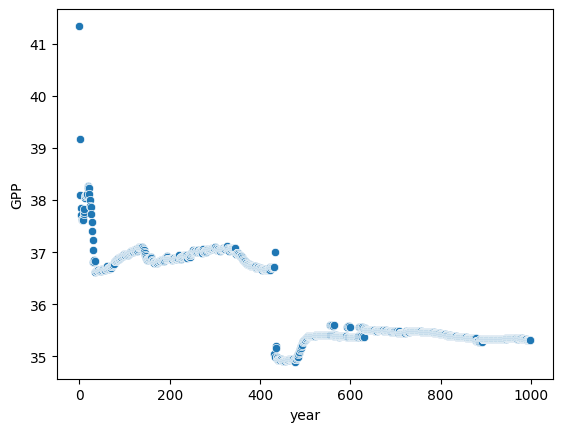

In [58]:
sns.scatterplot(data=yearly_gpp, x='year', y='GPP')

In [59]:
deepc_ds = nc.Dataset('/data/workflows/poker_flats_merged_data/output/DEEPC_yearly_eq.nc')
deepc = deepc_ds.variables['DEEPC'][:, y_x[0], y_x[1]]
year=np.array([i for i in range(0, len(deepc))]).astype(np.uint16)
deepc_df = pd.DataFrame({'year': year, 'DEEPC': deepc})

<AxesSubplot:xlabel='year', ylabel='DEEPC'>

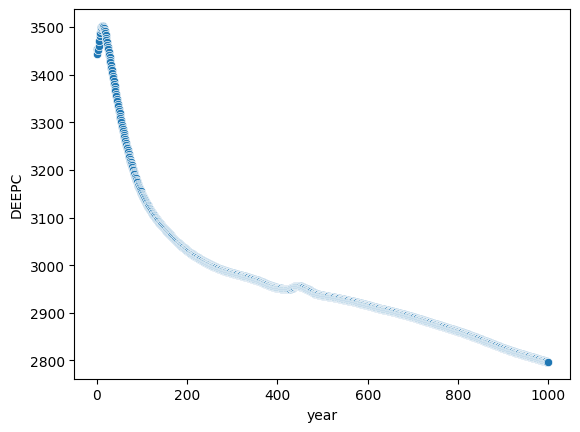

In [60]:
sns.scatterplot(data=deepc_df, x='year', y='DEEPC')

<AxesSubplot:xlabel='year', ylabel='RH'>

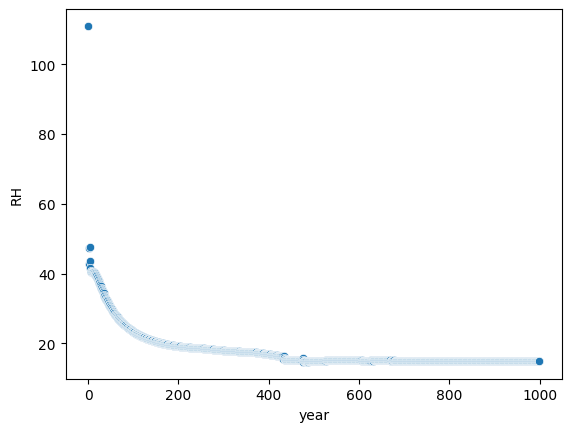

In [61]:
sns.scatterplot(data=yearly_gpp, x='year', y='RH')

<AxesSubplot:xlabel='year', ylabel='LWC'>

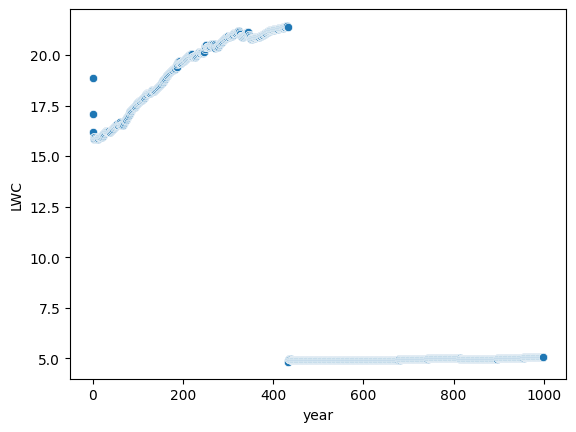

In [62]:
sns.scatterplot(data=yearly_gpp, x='year', y='LWC')